In [1]:
import pandas as pd
import numpy as np 
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import gc
import lightgbm as lgb
import keras.backend as K
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
  
def calBS(row):
    
    T = row['TTM'] / 365.242
    
    if T == 0:
        T += 1 / 365.242
    
    r = row['ir_3m_mid'] / 100
    vol = row['obx_total_60D_vol'] 
    
    d1 = (np.log(row['obx_price'] / row['strike']) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(row['obx_price'] / row['strike']) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if row['type'] == "CALL":
        optionPrice = row['obx_price'] * stats.norm.cdf(d1) - row['strike'] * np.exp(-r * T) * stats.norm.cdf(d2)
    elif row['type'] == "PUT":
        optionPrice = row['strike'] * np.exp(-r * T) * stats.norm.cdf(-d2) - row['obx_price'] * stats.norm.cdf(-d1)

    return optionPrice

def calDeltaBS(row):
    
    T = row['TTM'] / 365.242
    
    if T == 0:
        T += 1 / 365.242
    
    r = row['ir_3m_mid'] / 100
    vol = row['obx_total_60D_vol'] 
    
    d1 = (np.log(row['obx_price'] / row['strike']) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(row['obx_price'] / row['strike']) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if row['type'] == 1:
        delta = stats.norm.cdf(d1) 
    elif row['type'] == 0:
        delta = stats.norm.cdf(d1) - 1

    return delta


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

SEED = 2019 
np.random.seed(SEED)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../input/thesis_data_all_cols.csv')
df = df.sort_values('date')

In [3]:
df['moneyness'] = df['obx_price'] / df['strike']
df['opt_id'] = df['type'].astype(str) + '_' + df['strike'].astype(str) + '_' + df['maturity_date'].astype(str)

stats_cols = ['market_price', 'strike', 'obx_price', 'TTM', 'obx_60D_vol', 'ir_3m_mid']
df[stats_cols].describe()

,market_price,strike,obx_price,TTM,obx_60D_vol,ir_3m_mid
count,556082.00000,556082.000000,556082.000000,556082.000000,556082.000000,556082.000000
mean,37.98147,543.120268,555.178373,107.102951,0.001376,1.480485
std,45.77118,153.283512,134.826822,93.918179,0.000515,0.531900
min,0.01000,250.000000,301.030000,0.000000,0.000678,0.605000
25%,2.67500,430.000000,453.977500,36.000000,0.000987,1.075000
50%,18.37500,500.000000,542.035300,73.000000,0.001218,1.340000
75%,60.87500,640.000000,625.190000,161.000000,0.001664,1.685000
max,331.25000,1080.000000,881.010000,372.000000,0.003294,3.230000


In [4]:
df = df[df.type == 'CALL']

volume_filter = df.groupby('opt_id')['volume'].max().reset_index()
no_volume = volume_filter[volume_filter.volume == 0].opt_id

df = df.set_index('opt_id').drop(no_volume, axis=0)

In [5]:
df = df.reset_index()

In [6]:
df['T_t'] = df['TTM'] / 365.242
df['normalized_market_price'] = df['market_price'] / df['strike']

In [7]:
df.head()

,opt_id,date,market_price,ask_price,bid_price,open_price,high_price,low_price,strike,volume,open_interest,type,maturity,ir_1m_mid,ir_1m_bid,ir_1m_ask,ir_3m_mid,ir_3m_bid,ir_3m_ask,ir_6m_mid,ir_6m_bid,ir_6m_ask,obx_return,obx_60D_vol,obx_price,obx_total_return,obx_total_60D_vol,obx_total_price,maturity_date,TTM,moneyness,T_t,normalized_market_price
0,CALL_415.0_2011-07-21,2011-01-18,23.000,NaN,NaN,23.000,23.000,23.000,415.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,0.976434,0.503776,0.055422
1,CALL_410.0_2011-07-21,2011-01-18,25.750,NaN,NaN,25.750,25.750,25.750,410.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,0.988341,0.503776,0.062805
2,CALL_405.0_2011-07-21,2011-01-18,28.500,NaN,NaN,28.500,28.500,28.500,405.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,1.000543,0.503776,0.070370
3,CALL_400.0_2011-07-21,2011-01-18,31.875,NaN,NaN,31.875,31.875,31.875,400.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,1.013050,0.503776,0.079687
4,CALL_395.0_2011-07-21,2011-01-18,34.875,NaN,NaN,34.875,34.875,34.875,395.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,1.025873,0.503776,0.088291


In [8]:
cutoff = int(np.round(df.shape[0] * 0.8))
X_trn, y_trn = df[:cutoff].copy(), df[:cutoff]['normalized_market_price'].copy()
X_val, y_val = df[cutoff:].copy(), df[cutoff:]['normalized_market_price'].copy()

In [9]:
# from keras.layers import Input, Dense
# from keras.models import Model

# # This returns a tensor
# inputs = Input(shape=(2,))

# Plotting 

# # a layer instance is callable on a tensor, and returns a tensor
# x = Dense(128, activation='relu')(inputs)
# x = Dense(64, activation='relu')(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(16, activation='relu')(x)
# predictions = Dense(1)(x)

# # This creates a model that includes
# # the Input layer and three Dense layers
# model = Model(inputs=inputs, outputs=predictions)

# plot_model(model, to_file='model_plot.pdf', show_shapes=True, show_layer_names=True)

def build_nn_model(feats):
    model = models.Sequential()
    
    model.add(layers.Dense(128, activation='relu',
                            input_shape=(len(feats),)))  
    
    model.add(layers.Dense(64, activation='relu'))  
    
    model.add(layers.Dense(32, activation='relu'))   
    
    model.add(layers.Dense(16, activation='relu'))
    
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
    
    return model



def train_nn(X_train, y_train, X_validation, y_validation, feats):

    train_epochs = 200
    batch_size = 128

    train_x, train_y = X_train[feats], y_train
    valid_x, valid_y = X_validation[feats], y_validation

    train_oof = np.zeros(train_x.shape[0])

    nn_model = build_nn_model(feats)
    file_path = "nn_hedging.hdf5"

    early_stop = EarlyStopping(patience=10)
    lr_schd = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=5e-5, verbose=0)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)

    history = nn_model.fit(x=train_x, y=train_y,
                    validation_data=(valid_x, valid_y),
                    epochs=train_epochs, verbose = 1, batch_size=batch_size, 
                    callbacks = [early_stop, lr_schd, check_point])

    nn_model.load_weights(file_path) # load weight with best validation score

    train_oof = nn_model.predict(valid_x, batch_size=batch_size).ravel()

    print("nn rmse : {}".format(rmse(valid_y, train_oof)))
    print("nn mse : {}".format(mean_squared_error(valid_y, train_oof)))
    print("nn mae : {}".format(mean_absolute_error(valid_y, train_oof)))
    print("nn me : {}".format((valid_y - train_oof).mean()))
    
    return nn_model, train_oof

In [10]:
fts_to_use = ['moneyness', 'T_t']
nn_model, train_oof = train_nn(X_trn, y_trn, X_val, y_val, feats=fts_to_use)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 120646 samples, validate on 30161 samples
Epoch 1/200
120646/120646 [==============================] - 4s 34us/step - loss: 8.2846e-04 - mean_squared_error: 8.2846e-04 - val_loss: 8.8870e-05 - val_mean_squared_error: 8.8870e-05

Epoch 00001: val_loss improved from inf to 0.00009, saving model to nn_hedging.hdf5
Epoch 2/200
120646/120646 [==============================] - 3s 25us/step - loss: 2.3727e-04 - mean_squared_error: 2.3727e-04 - val_loss: 1.4443e-04 - val_mean_squared_error: 1.4443e-04

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/200
120646/120646 [==============================] - 3s 25us/step - loss: 1.7882e-04 - mean_squared_error: 1.7882e-04 - val_loss: 1.4682e-04 - val_mean_squared_error: 1.4682e-04

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/200
120646/120646 [==============================] - 3s 25us/step - loss: 

In [11]:
X_val['nn_price'] = train_oof * X_val['strike']
rmse(X_val.market_price, X_val.nn_price)

3.873698175847094

lightgbm training 

In [12]:
df.columns

Index(['opt_id', 'date', 'market_price', 'ask_price', 'bid_price',
       'open_price', 'high_price', 'low_price', 'strike', 'volume',
       'open_interest', 'type', 'maturity', 'ir_1m_mid', 'ir_1m_bid',
       'ir_1m_ask', 'ir_3m_mid', 'ir_3m_bid', 'ir_3m_ask', 'ir_6m_mid',
       'ir_6m_bid', 'ir_6m_ask', 'obx_return', 'obx_60D_vol', 'obx_price',
       'obx_total_return', 'obx_total_60D_vol', 'obx_total_price',
       'maturity_date', 'TTM', 'moneyness', 'T_t', 'normalized_market_price'],
      dtype='object')

In [13]:
import lightgbm as lgb

cutoff = int(np.round(df.shape[0] * 0.8))
X_trn, y_trn = df[:cutoff].copy(), df[:cutoff]['market_price'].copy()
X_val, y_val = df[cutoff:].copy(), df[cutoff:]['market_price'].copy()

In [14]:
feats = ['TTM', 'obx_60D_vol', 'ir_3m_mid', 'strike', 'obx_price', 'moneyness']

lgb_params = {'application': 'regression',
 'boosting': 'gbdt',
 'metric': 'rmse',
 'num_leaves': 4,
 'max_depth': 3,
#  'bagging_fraction': 0.7719557373298434,
#  'bagging_freq': 2,
#  'feature_fraction': 0.5136148006695185,
#  'subsample': 0.6578437524190227,
#  'reg_alpha': 0.14880454817636346,
#  'reg_lambda': 2.9623866226639755,
 'learning_rate': 0.01,
 'verbosity': -1,
 'seed': 2019}

xgtrain = lgb.Dataset(X_trn[feats], label=y_trn,
                  feature_name=feats)
xgvalid = lgb.Dataset(X_val[feats], label=y_val,
                  feature_name=feats)

evals_results = {}

clf = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgtrain, xgvalid],  
                 valid_names=['train', 'valid'], 
                 evals_result=evals_results, 
                 num_boost_round=50000,
                 early_stopping_rounds=100,
                 verbose_eval=100)

X_val['lgb_price'] = clf.predict(X_val[feats], num_iteration=clf.best_iteration)
rmse(X_val.market_price, X_val.lgb_price)

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 13.114	valid's rmse: 26.1662
[200]	train's rmse: 8.06007	valid's rmse: 20.3989
[300]	train's rmse: 5.66986	valid's rmse: 17.5641
[400]	train's rmse: 4.4478	valid's rmse: 15.9578
[500]	train's rmse: 3.80778	valid's rmse: 14.7663
[600]	train's rmse: 3.47258	valid's rmse: 13.9579
[700]	train's rmse: 3.24272	valid's rmse: 13.311
[800]	train's rmse: 3.08944	valid's rmse: 12.7555
[900]	train's rmse: 2.98055	valid's rmse: 12.4221
[1000]	train's rmse: 2.89708	valid's rmse: 12.1596
[1100]	train's rmse: 2.82882	valid's rmse: 11.9655
[1200]	train's rmse: 2.76467	valid's rmse: 11.8665
[1300]	train's rmse: 2.70976	valid's rmse: 11.7882
[1400]	train's rmse: 2.66086	valid's rmse: 11.7033
[1500]	train's rmse: 2.62063	valid's rmse: 11.6334
[1600]	train's rmse: 2.58344	valid's rmse: 11.5704
[1700]	train's rmse: 2.54614	valid's rmse: 11.504
[1800]	train's rmse: 2.51712	valid's rmse: 11.4769
[1900]	train's rmse: 2.49123	val

11.389457941036298

In [15]:
valid's rmse: 11.3895

SyntaxError: EOL while scanning string literal (<ipython-input-15-da1756f69e11>, line 1)

In [16]:
X_val['nn_price'] = train_oof * X_val['strike']

In [17]:
for price in ['nn_price', 'lgb_price']:

    print(price)
    print('rmse : ', rmse(y_val, X_val[price]))
    print('mse : ', mean_squared_error(y_val, X_val[price]))
    print('mae : ', mean_absolute_error(y_val, X_val[price]))
    print('me : ', (y_val - X_val[price]).mean())
    print('\n')


nn_price
rmse :  3.873698175847094
mse :  15.005537557561103
mae :  2.275737655071674
me :  -0.5902826270550063


lgb_price
rmse :  11.389457941036298
mse :  129.7197521906348
mae :  6.371697630417094
me :  5.965567816338257




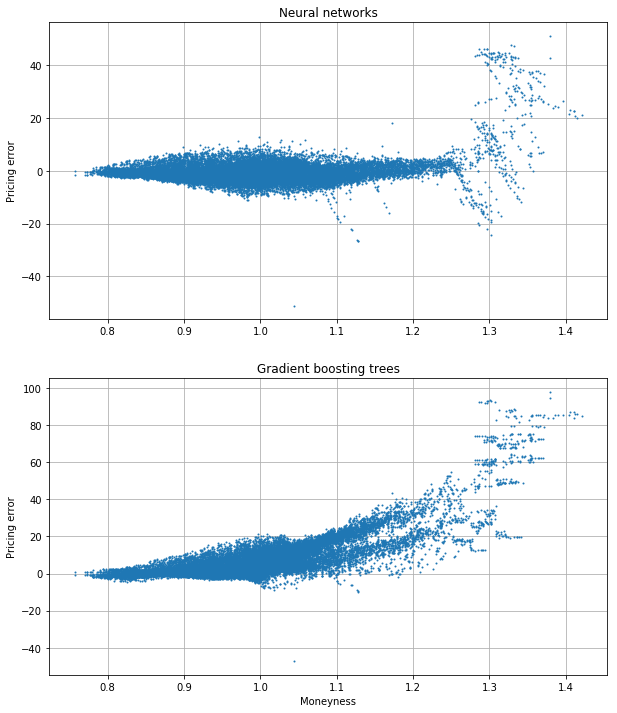

In [18]:
fig = plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.title("Neural networks")
plt.ylabel('Pricing error')
plt.grid(True)
fig = plt.plot(X_val['moneyness'], y_val - X_val['nn_price'], linestyle='', marker='o', markersize=1)

plt.subplot(2, 1, 2)
plt.title('Gradient boosting trees')
plt.xlabel('Moneyness')
plt.ylabel('Pricing error')
plt.grid(True)
fig = plt.plot(X_val['moneyness'], y_val - X_val['lgb_price'], linestyle='', marker='o', markersize=1)

plt.savefig("non_parametric_pricing_error.pdf", bbox_inches='tight')

In [19]:
X_val.to_pickle('non_param_errors.pkl')